# Simulating Queuing Systems

Queuing theory is one of the foundations for the analysis of discrete-event systems. This notebook introduces the nomenclature and terminology of queuing theory that will be used in later applications.

## Examples of Queues

### Manufacturing Lines

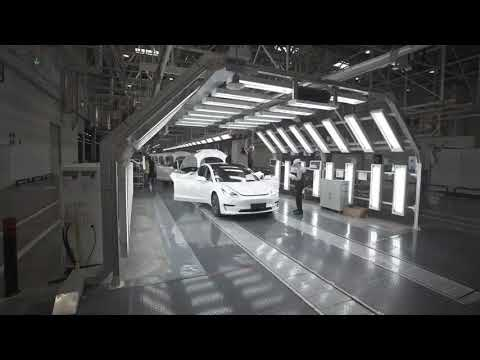

In [109]:
from IPython.display import YouTubeVideo
YouTubeVideo('yUVuiZUhbyA', width=560, height=315)


[Tesla China - Shanghai Gigafactory production line](https://electrek.co/2020/08/31/tesla-video-production-gigafactory-shanghai-alien-dreadnought/?fbclid=IwAR2jHUZMQG4Gl77ugYHvm3DTq-zV5iOuN3bMNePzJswvfY_VVgYP3W7pSZQ).


### Service Lines

![mathworks queue](https://blogs.mathworks.com/images/seth/2015Q1/queues.png)

## Concepts

### Nomenclature


* Servers
* Arrival rate
* Departure rate
* Queuing area or waiting area

### Service Disciplines (of many possibilities)

* First-in-first-out (FIFO or FCFS)
* Last in first out (LIFO)
* Shortest job first
* Priority queue, no interruption
* Priority queue with premption
* Earliest due date

## Poisson Process

Poisson processes describe the occurance of independent random events. Examples:

* Arrival of customers, orders, or other entities from totally independent sources.
* Machine failures when characterized by a mean time between failures (MTBF)
* Physical phenomena like molecules striking a surface, meteor strikes.

Poisson processes are a useful approximation for many simulations, and also very easy to implement in practice. This section introduces some theory before describing a typical implementation.

### Binomial distribution

Suppose there is a probability $p$ of an event occurring in a short interval. We'll assume the interval is short enough that two or more events in the same interval would be extremely unlikely. Assuming each event is independent, the probability of seeing $k$ events in $n$ intervals is given by the binomial distribution

$$\text{Binomial}(k | n, p) = \frac{n!}{k! (n-k)!} p^k (1 - p)^{n-k}$$

The term $p^k (1 - p)^{n-k}$ is the probability of seeing a particular sequence of $k$ intervals with events and $n-k$ intervals with no events, assuming all of the events are independent of one another. The multiplier $\frac{n!}{k! (n-k)!}$ is the number of different sequences that can be constructed from $k$ events occurring in $n$ intervals.

Text(0.5, 1.0, 'Binomial Distribution n=20, p=0.2')

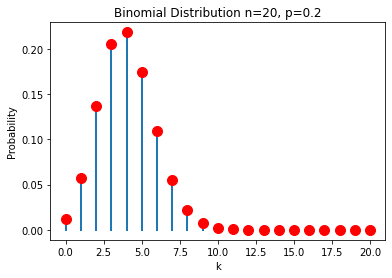

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

def factorial(n):
    return 1 if n<=1 else n * factorial(n-1)

def combination(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

def binomial(k, n, p):
    return combination(n, k) * p**k * (1-p)**(n-k)

n = 20
p = 0.20

for k in range(0, n+1):
    y = binomial(k, n, p)
    plt.plot([k, k], [0, y], 'C0', lw=2)
    plt.plot(k, y, 'r.', ms=20)
plt.xlabel('k')
plt.ylabel('Probability')
plt.title(f"Binomial Distribution n={n}, p={p}")

### Poisson distribution

Now imagine the events are occuring at an average rate $r$ of events per unit time. In period $t$ there would be, on average, $r t$ events. If that period is broken into $n$ intervals then 

$$ p = \frac{rt}{n}$$

which leads to the Poisson distribution 

$$\begin{align*}
\text{Poisson}(k | r, t) & = 
\lim_{n\rightarrow\infty}\text{Binomial}(k | n, \frac{rt}{n}) \\
& = \lim_{n\rightarrow\infty} \frac{n!}{k! (n-k)!} (\frac{rt}{n})^k (1 - \frac{rt}{n})^{n-k}
\end{align*}$$

We're interested in the limit $n\rightarrow\infty$. Without detailing the math, the limit works out to be

$$\text{Poisson}(k | r, t) = \frac{(rt)^k e^{-rt}}{k!}$$

which is the probability of seeing $k$ events in an interval of length $t$ when the average rate is $r$ events per unit time.

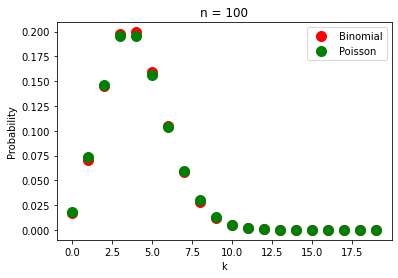

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def factorial(n):
    return 1 if n<=1 else n * factorial(n-1)

def combination(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

def binomial(k, n, p):
    return combination(n, k) * p**k * (1-p)**(n-k)

def poisson(k, r, t):
    return (r*t)**k * np.exp(-r*t)/factorial(k)

t = 2.0
r = 2.0

n = 100
p = r*t/n

k = range(0, 20)
plt.plot(k, [binomial(k, n, p) for k in k], 'r.', ms=20, label="Binomial")
plt.plot(k, [poisson(k, r, t) for k in k], 'g.', ms=20, label="Poisson")
plt.xlabel("k")
plt.ylabel("Probability")
plt.title(f"n = {n}")
plt.legend()


### Waiting time between events

Suppose an event has just occurred. What is the probability of no additional events in the next $t$ units of time? This is calculated with the Poisson distribution where $k=0$.

$$\text{Poisson}(0 | r, t) = e^{-r t}$$

We can treat this as the probability distribution for the time period between events. We refer to this as the exponential distribution

$$\text{Exponential}(t | r) =  e^{-r t}$$

This fact is useful in creating simulations of independent random events. For a given rate $r$, we sample values from an exponential distribution. 

## Simulating a Poisson Process in SimPy

Poisson processes are easy to implement in SimPy. A single parameter, commonly denoted as $r$ or $\lambda$, is required to specify the average rate of occurance in units of number per unit time. For example, a value $\lambda = 4.2 \text{ min}^{-1}$ corresponds to an average of 4.2 events per minute.

An alternative specification is so express the mean time between events. The rate of machine failures, for example, is typically specified as "mean time between failures" (MTBF). In these cases, $r = \lambda = \frac{1}{\bar{\tau}}$ where $\bar{\tau}$ is the mean time between events.

Once the mean rate has been determined, the time between events can be simulated by drawing samples from an exponential distribution

$$\text{Exponential}(t | r) =  e^{-r t}$$

The following cell demonstrates the simulation of a Poisson process with an average $r$ events per unit time.

In [121]:
%matplotlib inline
import simpy
import random
import matplotlib.pyplot as plt

# average rate: events per unit time
r = 2.0 

def arrival(r):
    while True:
        yield env.timeout(random.expovariate(r))
        data_log.append(env.now)

data_log = []  
env = simpy.Environment()
env.process(arrival(r))
env.run(10000)

Visualization

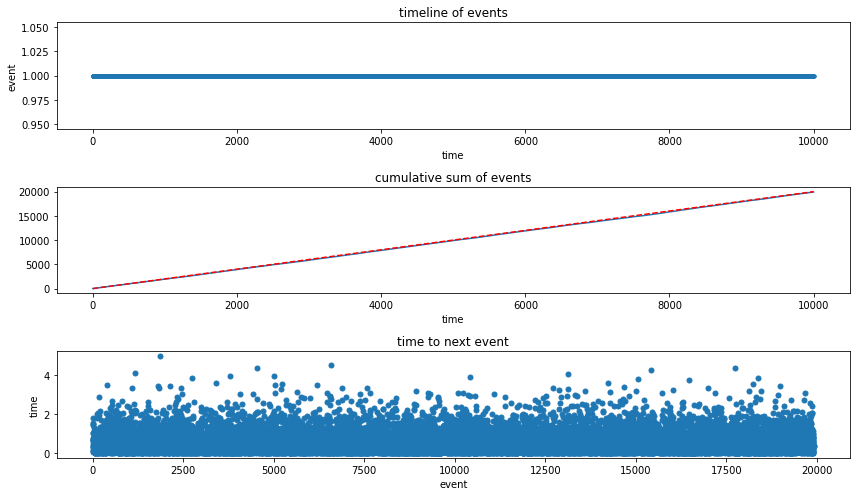

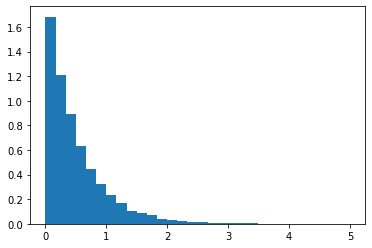

In [122]:
fig, ax = plt.subplots(3, 1, figsize=(12, 7))
ax[0].plot(data_log, np.ones((len(data_log), 1)), '.')
ax[0].set_xlabel('time')
ax[0].set_ylabel('event')
ax[0].set_title('timeline of events')

ax[1].plot(data_log, range(1, len(data_log)+1))
ax[1].plot(data_log, r*np.array(data_log), 'r--')
ax[1].set_xlabel("time")
ax[1].set_title("cumulative sum of events")

ax[2].plot(np.diff(data_log), '.', ms=10)
ax[2].set_xlabel("event")
ax[2].set_ylabel("time")
ax[2].set_title("time to next event")

plt.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.hist(np.diff(data_log), bins=30, density=True);

## Kendall notation for queues

Kendall notation is a standardized methods to describe and classify queues. The notation consists of three factors written as A/S/c where where A describes the arrival process, S the service process, and c is the number of servers attending the queue.

* $A/S/c$
    * $A$: statistical nature of the arrival process 
    * $S$: Statistical nature of the service process 
    * $c$: Number of servers at the queue node
    
* Typical Statistics
    * D: Deterministic (average arrival rate $\lambda$)
    * M: Markov or memoryless (average arrival rate $r$)
    * G: General or arbitrary distribution (mean $\mu$ and standard deviation $\simga$ or variance $\sigma^2$)
    
Example: M/D/1

![Aircraft queue](https://i0.wp.com/nats.aero/blog/wp-content/uploads/2013/08/aircraft-queue-e1377251576844.jpg?ssl=1)

Example: M/M/8

![Call Center](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Emergency_Call_Center_112.jpg/640px-Emergency_Call_Center_112.jpg)

## Example: Simulation of an Order Processing Queue

A chemical storeroom processes orders for a large research campus. At peak loads it is expected to receive an average of one order every 12 minutes. The time required to process each order is a fixed 10 minutes. 

1. Describe the process using the Kendall notation: M/D/1

2. Create a simulation of the order queue that operates for 8 hours. Determine the average time between the arrival and completion of an order, and determine the average queue length. 

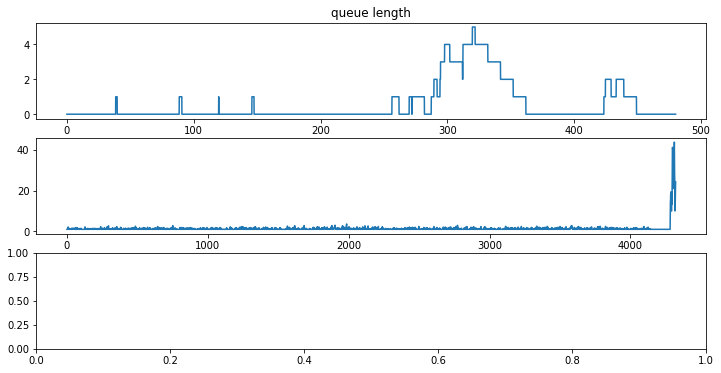

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd

# time unit = minutes

order_log = []    # log data on order processing
queue_log = []    # log data on queue length

# log time and queue_length at regular time steps
def queue_logger(t_step=1.0):
    while True:
        queue_log.append([env.now, len(queue.items)])
        yield env.timeout(t_step)

# generate and place orders on the queue at a specified rate
def order_generator(order_rate):
    order_id = 1
    while True:
        yield env.timeout(random.expovariate(order_rate))
        yield queue.put([order_id, env.now])
        order_id += 1
    
# process orders from the queue with a specified processing time
def server(t_process):
    while True:
        order_id, time_placed = yield queue.get()
        yield env.timeout(t_process)
        log.append([order_id, time_placed, env.now])
        
env = simpy.Environment()
queue = simpy.Store(env)

env.process(queue_logger(0.1))
env.process(order_generator(1/12.0))
env.process(server(10.0))

env.run(until=8*60)

queue_df = pd.DataFrame(queue_log, columns=["time", "queue length"])
order_df = pd.DataFrame(order_log, columns=["order id", "start", "finish"])

fig, ax = plt.subplots(3, 1, figsize=(12, 6))

ax[0].plot(queue_df["time"], queue_df["queue length"])
ax[0].set_xlabel("time / min")
ax[0].set_title("queue length")

order_df["elapsed"] = order_df["finish"] - order_df["start"]
ax[1].plot(df_orders["elapsed"])
#ax[1].hist(df_orders["elapsed"], bins=int(np.sqrt(len(df_orders.index))));
#ax[1].set_xlim((0,ax[1].get_xlim()[1]))

## Batch Processing Example  (NEEDS REWORK)

**Note that this model is incorrect! Update expected soon.**

Schultheisz, Daniel, and Jude T. Sommerfeld. "Discrete-Event Simulation in Chemical Engineering." Chemical Engineering Education 22.2 (1988): 98-102.

![Batch Process](figures/BatchProcess.png)

    "... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 ± 30 minutes, uniformly distributed. The reaction time in a given reactor is 335 ± 60 minutes, and the distillation time in the still is 110 ± 25 minutes, both times uniformly distributed. The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty. The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue im- mediately upstream of the reactor.""
    
    G/G/3

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
import simpy

The first step in any SimPy simulation is to setup the simulation environment and define any shared resources that may be used in the course of the simulation.

In [33]:
env = simpy.Environment()

In this application, the batch process is conceptually modeled as a sequence of components that process individual orders. Here we use the SimPy [Store](http://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html) primative to describe the reactor queue and storage tank. These components will accept orders corresponding to batches, and process them on a first-in, first-out (FIFO) basis.  We'll put no upper limit on the orders that can be stored in the reactor queue, but we will establish the storage tank so that it can accept only one batch at a time.

In [34]:
customer_order_queue = simpy.Store(env)

Next we turn to the process that will generate the customer orders. The function `order_generator` begins by initializing a counter that will be used to assigned a consecutive order numbers, after which `order_generator` enters a loop that will create a total of 100 orders for the simulation.

At the start of each loop, `order_generator` issues a yield statement that will return control back to the simulation for a simulated period extending into the future. The period is given by a random number uniformly distributed in the range 115 +/- 30 minutes. 

Technically speaking, the `yield` statement defines the function as a generator of events, and provides the means for `order_generator` to communicate with other processes and to be controlled by the simulation environment. At least one `yield` statement is needed in every function that will simulate a SimPy process.

Once control returns to `order_generator`, the order counter is incremented and a second yield used to request the simuation environment put the order into the reactor queue. On return the order_generator completes the loop by writing an entry into the simulation log.

The `env.process()` creates order generator within the simulation environment. The actual simulation, however, happens later when we use `env.run()` after creating the other needed processes for this application. 

In [36]:
def order_generator(env, customer_order_queue):
    orderID = 1
    while orderID <= 100:
        yield env.timeout(random.uniform(115-30,115+30))
        yield customer_order_queue.put(orderID)
        writeLog(env, orderID, 'Stage 0', 'Queue')
        orderID += 1
        
env.process(order_generator(env, customer_order_queue))

<Process(order_generator) object at 0x7fa83184c6d0>

The user is responsible for managing the logging of simulation events.  A simple but useful approach is to initialize a Python list, then append data containing a description of the event and time at which it occurred. Later we'll see how to process this log to get the desired process performance indicators.

In [37]:
log = []
def writeLog(env, orderID, stage, event):
    log.append([orderID, stage, event, env.now])

In [38]:
env.run()

In [39]:
log

[[1, 'Stage 0', 'Queue', 139.7912689063472],
 [2, 'Stage 0', 'Queue', 281.90183364963775],
 [3, 'Stage 0', 'Queue', 383.9453070616212],
 [4, 'Stage 0', 'Queue', 473.3172502050613],
 [5, 'Stage 0', 'Queue', 579.7437399430546],
 [6, 'Stage 0', 'Queue', 700.9082069695478],
 [7, 'Stage 0', 'Queue', 797.3263526092184],
 [8, 'Stage 0', 'Queue', 938.8568078270348],
 [9, 'Stage 0', 'Queue', 1055.831373019922],
 [10, 'Stage 0', 'Queue', 1158.4320187228143],
 [11, 'Stage 0', 'Queue', 1284.9471277131183],
 [12, 'Stage 0', 'Queue', 1373.0125904139793],
 [13, 'Stage 0', 'Queue', 1469.363988086261],
 [14, 'Stage 0', 'Queue', 1571.3833209362244],
 [15, 'Stage 0', 'Queue', 1699.2527666939222],
 [16, 'Stage 0', 'Queue', 1822.6510441755897],
 [17, 'Stage 0', 'Queue', 1915.304591044007],
 [18, 'Stage 0', 'Queue', 2041.8743538454528],
 [19, 'Stage 0', 'Queue', 2155.278139269896],
 [20, 'Stage 0', 'Queue', 2290.0547002600742],
 [21, 'Stage 0', 'Queue', 2393.5362204948715],
 [22, 'Stage 0', 'Queue', 2506.28

Next we create a function `batch_reactor` that will be use to create processes corresponding to each of the three batch reactors. Each reactor is assigned a unique name so they can be distinguished in the simulation log.

The batch reactors have three interactions with the simulation environment. The first is to get an orderID from the reactor_queue. The batch_reactor yields to the simulation environment until an order is ready for processing. Once the processing can start, and suitable event is written to the log, the process waits a period of time corresponding the length of the reaction, and the order put into the storage_tank.  The reactor will wait until the storage tank is ready to accept a new batch.

`env.process()` is called three times to put three copies of the batch_reactor process into the simulation environment.

In [19]:
def batch_reactor(name, env, reactor_queue, storage_tank):
    while True:
        orderID = yield reactor_queue.get()
        writeLog(env, orderID, 'Stage 1', name)
        yield env.timeout(random.uniform(335-60,335+60))
        writeLog(env, orderID, 'Stage 2', name)
        yield storage_tank.put(orderID)
        writeLog(env, orderID, 'Stage 3', 'Storage')
        
env.process(batch_reactor('Reactor A', env, reactor_queue, storage_tank))
env.process(batch_reactor('Reactor B', env, reactor_queue, storage_tank))
env.process(batch_reactor('Reactor C', env, reactor_queue, storage_tank))

<Process(batch_reactor) object at 0x7fa8312b8f10>

The last process to model is the batch still. Similar to the reactor model, `batch_still` yields control while waiting for an orderID to be retrieved from a preceding unit. Once an order has been received from the storage_tank, a message is written to the simulation log, time is yielded to the simulation environment corresponding to the time required for distillation, and then a final completion message is written to the log.

In [20]:
def batch_still(name, env, storage_tank):
    while True:
        orderID = yield storage_tank.get()
        writeLog(env, orderID, 'Stage 4', name)
        yield env.timeout(random.uniform(110-25,110+25))
        writeLog(env, orderID, 'Stage 5', 'complete')

env.process(batch_still('Still A', env, storage_tank))

<Process(batch_still) object at 0x7fa8312b83d0>

We're now ready to run the the simulation.  In this case the simulation is limited to the 100 orders generated in the `order_generator` process. Simulation is complete once all of the resulting events have been processed.

In [21]:
env.run()

print('Simulation complete.')
print(len(log), ' messages have been logged.')

Simulation complete.
600  messages have been logged.


## Processing the Simulation Log

In [22]:
def process_log(log):

    df = pd.DataFrame([[a,b,c,t] for (a,b,c,t) in log])
    df = df.pivot(index=0,columns=1,values=3).reset_index()
    df = df.set_index([0]).dropna()
    df.index.rename('OrderID',inplace=True)

    stage1 = df['Stage 1']-df['Stage 0']
    stage2 = df['Stage 2']-df['Stage 1']
    stage3 = df['Stage 3']-df['Stage 2']
    stage4 = df['Stage 4']-df['Stage 3']
    stage5 = df['Stage 5']-df['Stage 4']

    print('Mean Order Completion = {0:6.1f} min.\n'.format((df['Stage 5'] - df['Stage 0']).mean()))

    print('Mean Time in Process Stages:\n')
    print('     Reactor Queue = {0:6.1f} min.'.format(stage1.mean()))
    print('          Reactors = {0:6.1f} min.'.format(stage2.mean()))
    print('    Reactor Holdup = {0:6.1f} min.'.format(stage3.mean()))
    print('           Storage = {0:6.1f} min.'.format(stage4.mean()))
    print('             Still = {0:6.1f} min.'.format(stage5.mean()))

    print('\nUtilization\n')
    print('Reactor Utilization = {0:5.3f}'.format(stage2.sum()/3.0/(df['Stage 2'].max()-df['Stage 2'].min())))
    print('  Still Utilization = {0:5.3f}'.format(stage5.sum()/(df['Stage 5'].max()-df['Stage 5'].min())))
    
    stage1.hist(bins=30)
    plt.title('Distribution of Reactor Queue Times')
    plt.ylabel('Count')
    plt.xlabel('Minutes')

Mean Order Completion =  501.3 min.

Mean Time in Process Stages:

     Reactor Queue =   22.9 min.
          Reactors =  335.2 min.
    Reactor Holdup =    0.2 min.
           Storage =   34.1 min.
             Still =  109.0 min.

Utilization

Reactor Utilization = 0.960
  Still Utilization = 0.932


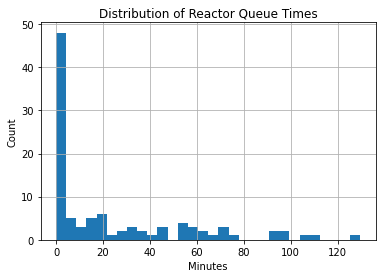

In [23]:
process_log(log)